In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#Database path
database_path = "hawaii.sqlite"

In [6]:
# Create engine
engine = create_engine(f"sqlite:///{database_path}")
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
#Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the most recent date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)
print(df)

('2017-08-23',)
                  date  precipitation
date                                 
2016-08-23  2016-08-23           0.00
2016-08-24  2016-08-24           0.08
2016-08-25  2016-08-25           0.08
2016-08-26  2016-08-26           0.00
2016-08-27  2016-08-27           0.00
...                ...            ...
2017-08-19  2017-08-19           0.09
2017-08-20  2017-08-20            NaN
2017-08-21  2017-08-21           0.56
2017-08-22  2017-08-22           0.50
2017-08-23  2017-08-23           0.45

[2230 rows x 2 columns]


Text(0, 0.5, 'Precipitation')

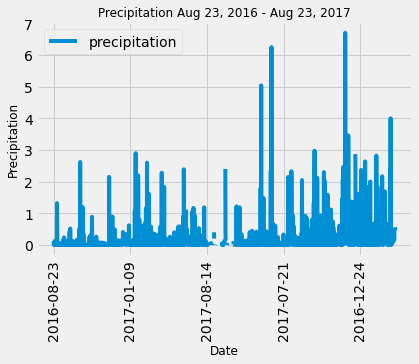

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(rot=90)

# Add title and axis names
plt.title('Precipitation Aug 23, 2016 - Aug 23, 2017', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Precipitation', fontsize=12)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Active_stations = session.query(Station.name, func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
Active_stations

[('WAIHEE 837.5, HI US', 2772),
 ('WAIKIKI 717.2, HI US', 2724),
 ('KANEOHE 838.1, HI US', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('PEARL CITY, HI US', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded of the most active station, 
# calculate the highest temperature recorded of the most active station, and the average temperature recorded of the most active station:

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

     temperature
0           80.0
1           79.0
2           81.0
3           79.0
4           78.0
..           ...
352         77.0
353         77.0
354         76.0
355         76.0
356         79.0

[357 rows x 1 columns]


Text(0.5, 1.0, 'Temperature Aug 02, 2016 - Aug 02, 2017')

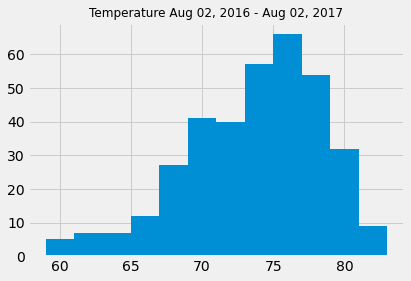

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Station with highest number of temperature observations
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Perform a query to retrieve the temperature for the most active station
results = session.query(Measurement.tobs).filter(Measurement.date >= prev_year).filter(Measurement.station=='USC00519281').all()

# Save the query results as a Pandas DataFrame 

df = pd.DataFrame(results, columns=['temperature'])
print(df)

# Plot the results as a histogram

df.hist(bins=12)
plt.title('Temperature Aug 02, 2016 - Aug 02, 2017', fontsize=12)

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
